# Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import types

# Patch for pickle compatibility
if 'recover_core_lib' not in sys.modules:
    fake = types.ModuleType('recover_core_lib')
    fake.compute_CAM2_translations_v3_cupy = lambda *a, **k: None
    sys.modules['recover_core_lib'] = fake

In [ ]:
%matplotlib widget

In [ ]:
# Data paths for all 6 cube positions
DATA_DIR = Path('/Users/eitanturok/good-vibrations/data/vibrations')
POSITION_PATHS = {
    1: DATA_DIR / 'cube_pos1_29_12_Time_19_16_40' / 'RECOVERY.npz',
    2: DATA_DIR / 'cube_pos2_29_12_Time_19_13_50' / 'RECOVERY.npz',
    3: DATA_DIR / 'cube_pos3_29_12_Time_19_29_43' / 'RECOVERY.npz',
    4: DATA_DIR / 'cube_pos4_29_12_Time_19_24_21' / 'RECOVERY.npz',
    5: DATA_DIR / 'cube_pos5_29_12_Time_19_22_12' / 'RECOVERY.npz',
    6: DATA_DIR / 'cube_pos6_29_12_Time_19_20_07' / 'RECOVERY.npz',
}

# Surface Vibrations

In [ ]:
def load_shifts(path: Path) -> tuple[np.ndarray, float]:
    """Load shifts and sampling frequency from a recovery file."""
    data = np.load(path, allow_pickle=True)
    shifts = data['all_shifts'][:, 1:]  # Skip first sample
    fs = data['run_opt'].item()['cam_params']['camera_FPS']
    timesteps = np.arange(shifts.shape[1]) / fs
    return shifts, fs, timesteps

In [ ]:
from scipy.signal import butter, sosfiltfilt

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter(order, [lowcut, highcut], fs=fs, btype='band', output='sos')
    return sosfiltfilt(sos, data)

In [ ]:
def filter_shifts(shifts, fs=1249, lowcut=50, highcut=None, order=5):
    if highcut is None: highcut = fs / 2 - 10  # Slightly below Nyquist frequency
    filtered_shifts = np.empty_like(shifts)
    for i in range(shifts.shape[0]):
        for j in range(shifts.shape[2]):
            filtered_shifts[i, :, j] = bandpass_filter(shifts[i, :, j], lowcut, highcut, fs, order)
    return filtered_shifts

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
import matplotlib.gridspec as gs

# -------------------------
# data
# -------------------------
n = 10
X, Y = np.meshgrid(np.arange(n), np.arange(n))

shifts = {}
for pos, path in POSITION_PATHS.items():
    _shifts, fs, timesteps = load_shifts(path)
    filtered_shifts = filter_shifts(_shifts, fs=fs, lowcut=50, highcut=fs//2 - 1, order=5)
    shifts[pos] = filtered_shifts

positions = list(shifts)
T = next(iter(shifts.values())).shape[1]

# -------------------------
# figure
# -------------------------
fig = plt.figure(figsize=(13, 9))
G = gs.GridSpec(5, 3, height_ratios=[4, 4, 0.7, 0.7, 0.4])
fig.suptitle("Surface Vibrations t=0", fontsize=16)
fig.subplots_adjust(hspace=0.5)

axes = [fig.add_subplot(G[i//3, i%3]) for i in range(len(positions))]
quivers = []

# -------------------------
# initial draw
# -------------------------
t0, s0 = 0, 1.0

for ax, pos in zip(axes, positions):
    v = shifts[pos][:, t0].reshape(n, n, 2)
    q = ax.quiver(X, Y, v[...,0], v[...,1], scale=s0)
    quivers.append(q)
    ax.set(title=f"Cube Position {pos}", aspect="equal", xlim=(-.5, n-.5), ylim=(-.5, n-.5))

# -------------------------
# sliders
# -------------------------
ax_t = fig.add_subplot(G[2, :])
ax_s = fig.add_subplot(G[3, :])

time = Slider(ax_t, "t", 0, T-1, valinit=t0, valstep=1)
scale = Slider(ax_s, "scale", .1, 10, valinit=s0)

# -------------------------
# update
# -------------------------
def redraw(_):
    t, s = int(time.val), scale.val
    for i, (ax, pos) in enumerate(zip(axes, positions)):
        quivers[i].remove()
        v = shifts[pos][:, t].reshape(n, n, 2)
        quivers[i] = ax.quiver(X, Y, v[...,0], v[...,1], scale=s)
        ax.set_title(f"Cube Position {pos}")
    fig.suptitle(f"Surface Vibrations t={t}", fontsize=16)
    fig.canvas.draw_idle()

time.on_changed(redraw)
scale.on_changed(redraw)

# -------------------------
# buttons
# -------------------------
L = Button(fig.add_subplot(G[4, 0]), "◀")
R = Button(fig.add_subplot(G[4, 2]), "▶")

L.on_clicked(lambda _: time.set_val(max(0, time.val - 1)))
R.on_clicked(lambda _: time.set_val(min(T-1, time.val + 1)))

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib.widgets import Slider, Button
from matplotlib.animation import FFMpegWriter

# -------------------------
# init
# -------------------------
def init_plot(shifts, n, scale_init):
    pos = list(shifts)
    X, Y = np.meshgrid(np.arange(n), np.arange(n))

    fig = plt.figure(figsize=(13, 9))
    G = gs.GridSpec(5, 3, height_ratios=[4, 4, .7, .7, .4])
    axs = [fig.add_subplot(G[i//3, i%3]) for i in range(len(pos))]
    qs = []

    for a, p in zip(axs, pos):
        v = shifts[p][:, 0].reshape(n, n, 2)
        qs += [a.quiver(X, Y, v[...,0], v[...,1], scale=scale_init)]
        a.set(title=f"Cube {p}", aspect="equal", xlim=(-.5, n-.5), ylim=(-.5, n-.5))

    fig.subplots_adjust(hspace=.5)
    return fig, axs, qs, pos, (X, Y)

# -------------------------
# update
# -------------------------
def update(fig, axs, qs, shifts, pos, n, t, s, X, Y):
    for i, p in enumerate(pos):
        v = shifts[p][:, t].reshape(n, n, 2)
        # qs[i].set_UVC(v[...,0], v[...,1])
        qs[i].remove()
        qs[i] = axs[i].quiver(X, Y, v[...,0], v[...,1], scale=s)
        axs[i].set_title(f"Cube {p}")
    fig.suptitle(f"Surface Vibrations t={t}")
    fig.canvas.draw_idle()

# -------------------------
# interactive
# -------------------------
def interactive(shifts, n, scale_init=1.0):
    T = next(iter(shifts.values())).shape[1]
    fig, axs, qs, pos, (X, Y) = init_plot(shifts, n, scale_init)
    G = axs[0].get_gridspec()

    # init + update sliders
    f = lambda _: update(fig, axs, qs, shifts, pos, n, int(t.val), s.val, X, Y)
    t = Slider(fig.add_subplot(G[2,:]), "t", 0, T-1, valinit=0, valstep=1).on_changed(f)
    s = Slider(fig.add_subplot(G[3,:]), "scale", .1, 10, valinit=scale_init).on_changed(f)

    # init + update buttons
    Button(fig.add_subplot(G[4,0]), "◀").on_clicked(lambda _: t.set_val(max(0,int(t.val)-1)))
    Button(fig.add_subplot(G[4,2]), "▶").on_clicked(lambda _: t.set_val(min(T-1,int(t.val)+1)))

    plt.show()
    return fig

# -------------------------
# video
# -------------------------
def save_video(shifts, n, scale=1.0, fps=30, out="vibes.mp4", dpi=150):
    T = next(iter(shifts.values())).shape[1]
    fig, axs, qs, pos, (X, Y) = init_plot(shifts, n, scale)
    w = FFMpegWriter(fps=fps, bitrate=1800)

    with w.saving(fig, out, dpi):
        for t in range(T):
            update(fig, axs, qs, shifts, pos, n, t, scale, X, Y)
            fig.canvas.draw()
            w.grab_frame()

    plt.close(fig)


In [9]:
n = 10

shifts = {}
for pos, path in POSITION_PATHS.items():
    _shifts, fs, timesteps = load_shifts(path)
    filtered_shifts = filter_shifts(_shifts, fs=fs, lowcut=50, highcut=fs//2 - 1, order=5)
    shifts[pos] = filtered_shifts

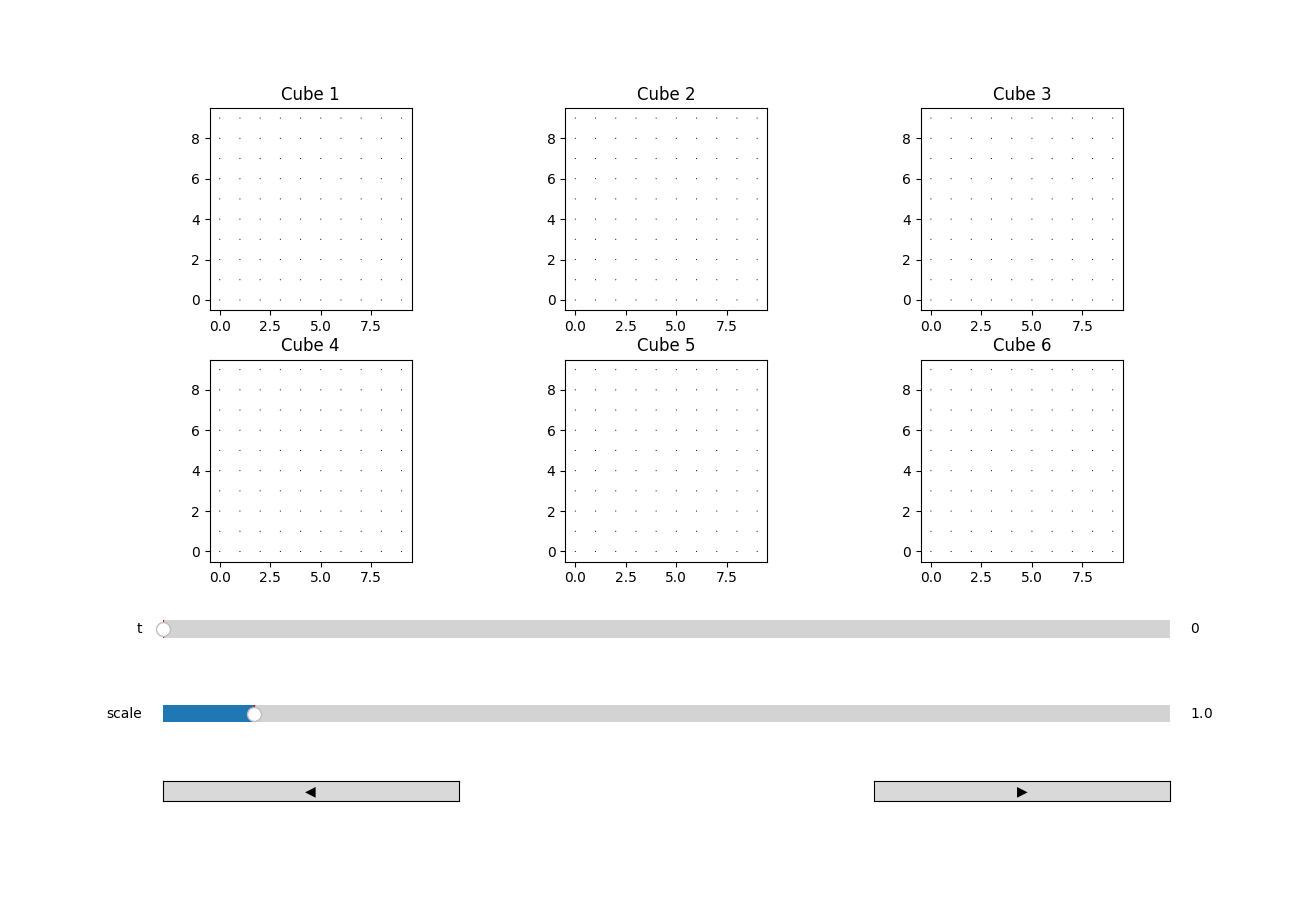

In [11]:
fig = interactive(shifts, n=n)

In [ ]:

save_surface_vibration_video(
    shifts=shifts,
    n=10,
    fps=60,
    scale=15,
    outfile="surface_vibrations.mp4",
)


# Compute FFT

In [19]:
def compute_fft_magnitude(shifts: np.ndarray, fs: float) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute FFT magnitudes

    Args:
        shifts: Shape (n_sensors, n_samples, 2) for x/y components
        fs: Sampling frequency in Hz

    Returns:
        freqs: Frequency bins
        magnitudes: Magnitude across all sensors and components
    """
    n_sensors, n_samples, _ = shifts.shape

    # Stack x and y components: (2*n_sensors, n_samples)
    stacked = np.vstack([shifts[:, :, 0], shifts[:, :, 1]])

    # Apply Hann window
    window = np.hanning(n_samples)
    windowed = stacked * window

    # Compute FFT magnitude
    fft_vals = np.fft.rfft(windowed, axis=1)
    magnitudes = np.abs(fft_vals)
    freqs = np.fft.rfftfreq(n_samples, d=1.0/fs)

    return freqs, magnitudes

In [46]:
# Load data for all positions
fft_data = {}
for pos, path in POSITION_PATHS.items():
    shifts, fs, timesteps = load_shifts(path)
    freqs, magnitudes = compute_fft_magnitude(shifts, fs)
    fft_data[pos] = {'freqs': freqs, 'magnitudes': magnitudes, 'timesteps': timesteps}
    print(f"Position {pos}: loaded {shifts.shape[0]} sensors, {shifts.shape[1]} samples")

Position 1: loaded 100 sensors, 29999 samples
Position 2: loaded 100 sensors, 29999 samples
Position 3: loaded 100 sensors, 29999 samples
Position 4: loaded 100 sensors, 29999 samples
Position 5: loaded 100 sensors, 29999 samples
Position 6: loaded 100 sensors, 29999 samples


# Average FFT

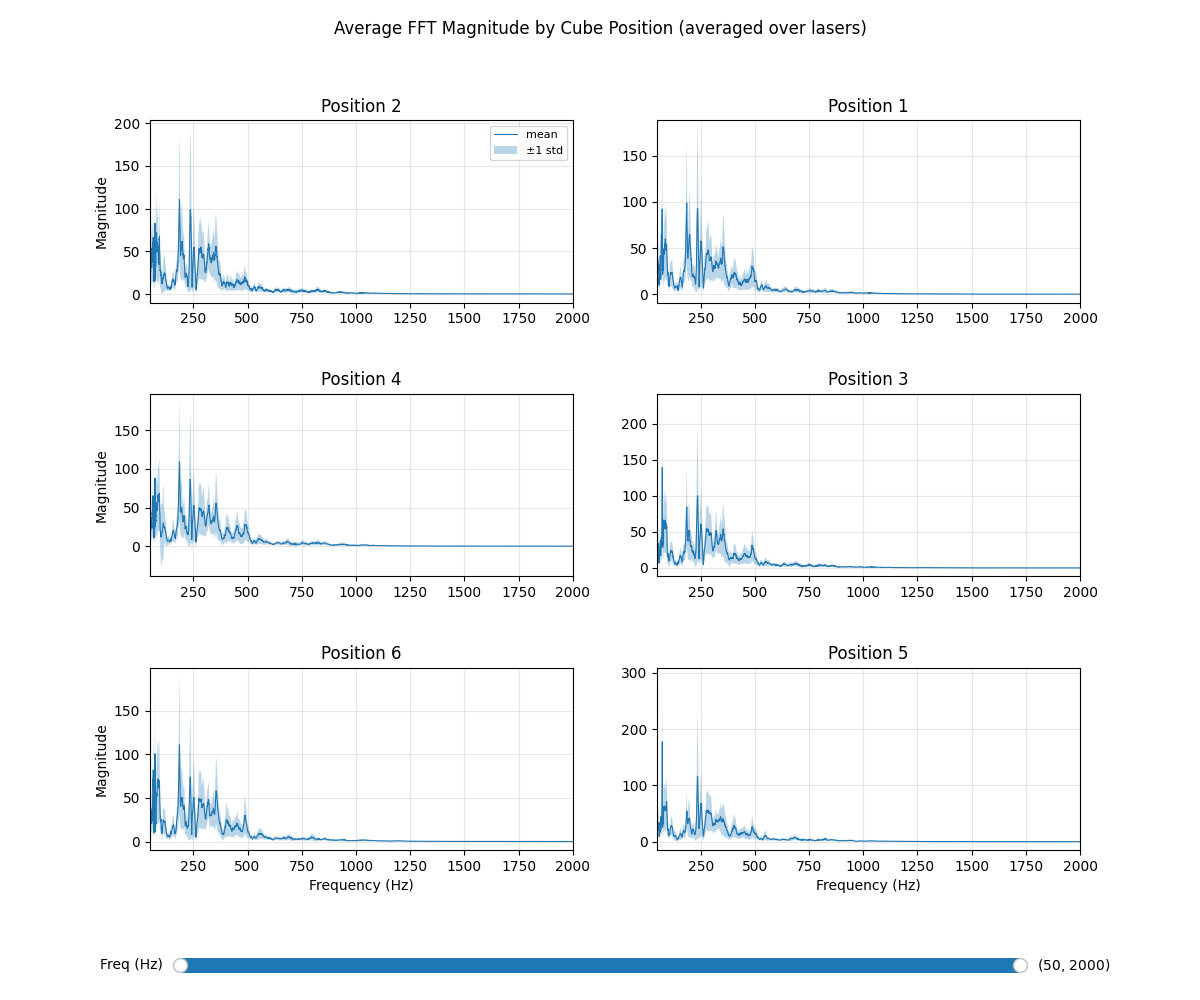

In [86]:
%matplotlib widget
from matplotlib.widgets import RangeSlider

# Visualization: 50-2000 Hz range with mean and std + interactive zoom
MIN_FREQ = 50
MAX_FREQ = 2000

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
fig.subplots_adjust(bottom=0.15, hspace=0.5)
axes = axes.flatten()
# top_axes = [ax.twiny() for ax in axes]

lines = []
fills = []

for idx, pos in enumerate([2, 1, 4, 3, 6, 5]):
    ax = axes[idx]
    ax_top = top_axes[idx]
    data = fft_data[pos]

    # Filter frequencies
    mask = (data['freqs'] >= MIN_FREQ) & (data['freqs'] <= MAX_FREQ)
    freqs = data['freqs'][mask]
    magnitudes = data['magnitudes'][:, mask]

    # Compute mean and std across sensors
    mean_mag = magnitudes.mean(axis=0)
    std_mag = magnitudes.std(axis=0)

    # Plot mean and std shading
    # line, = ax.semilogy(freqs, mean_mag, lw=0.8, label='mean') # plot in log scale
    line, = ax.plot(freqs, mean_mag, lw=0.8, label='mean')
    fill = ax.fill_between(freqs, mean_mag - std_mag, mean_mag + std_mag, alpha=0.3, label='±1 std')
    lines.append(line)
    fills.append(fill)

    # Setup axes
    ax.set_title(f'Position {pos}')
    ax.set_xlim(MIN_FREQ, MAX_FREQ)
    ax.grid(True, alpha=0.3, which='both')

    # ax_top.set_xlim(0, 6.0)
    # ax_top.set_xlabel('Timestep')
    # ax_top.tick_params(axis='x', labelsize=8)

axes[0].legend(loc='upper right', fontsize=8)

for ax in axes[-2:]:
    ax.set_xlabel('Frequency (Hz)')
for ax in axes[::2]:
    ax.set_ylabel('Magnitude')

fig.suptitle('Average FFT Magnitude by Cube Position (averaged over lasers)', fontsize=12)

# Add range slider for frequency zoom
ax_slider = fig.add_axes([0.15, 0.02, 0.7, 0.03])
slider = RangeSlider(ax_slider, 'Freq (Hz)', MIN_FREQ, MAX_FREQ, valinit=(MIN_FREQ, MAX_FREQ))

def update(val):
    freq_min, freq_max = val
    for ax in axes:
        ax.set_xlim(freq_min, freq_max)
    fig.canvas.draw_idle()

slider.on_changed(update)
plt.show()

# Stacked FFT

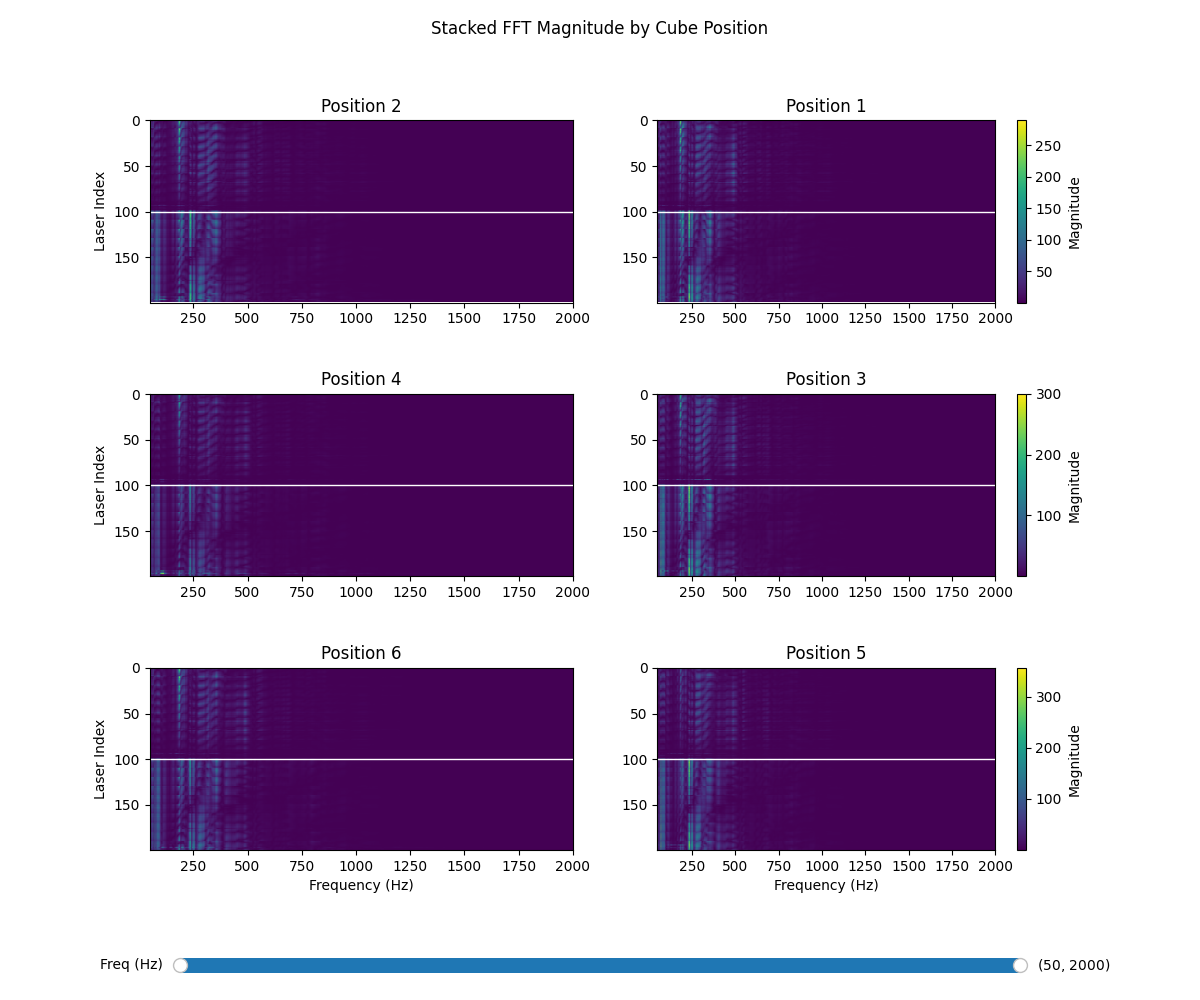

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
fig.subplots_adjust(bottom=0.15, hspace=0.5)
fig.suptitle('Stacked FFT Magnitude by Cube Position', fontsize=12)
axes = axes.flatten()


for idx, pos in enumerate([2, 1, 4, 3, 6, 5]):
    ax = axes[idx]
    data = fft_data[pos]

    # Filter frequencies
    mask = (data['freqs'] >= MIN_FREQ) & (data['freqs'] <= MAX_FREQ)
    freqs = data['freqs'][mask]
    magnitudes = data['magnitudes'][:, mask]

    # Display as image
    im = ax.imshow(
        magnitudes,
        aspect='auto',
        origin='upper',
        extent=[freqs[0], freqs[-1], magnitudes.shape[0] - 0.5, -0.5]
    )

    # Separator between x- and y-shift stacks
    ax.axhline(100, color='white', linewidth=1)

    ax.set(title=f"Position {pos}", xlim=(MIN_FREQ, MAX_FREQ))

    if pos%2 == 1:
        cbar = plt.colorbar(im)
        cbar.set_label("Magnitude")
    if idx in [4, 5]:
        ax.set(xlabel="Frequency (Hz)")
    if idx % 2 == 0:
        ax.set(ylabel="Laser Index")

# Add range slider for frequency zoom
ax_slider = fig.add_axes([0.15, 0.02, 0.7, 0.03])
slider = RangeSlider(ax_slider, 'Freq (Hz)', MIN_FREQ, MAX_FREQ, valinit=(MIN_FREQ, MAX_FREQ))

def update(val):
    freq_min, freq_max = val
    for ax in axes:
        ax.set_xlim(freq_min, freq_max)
    fig.canvas.draw_idle()

slider.on_changed(update)

plt.show()

# Surface Vibrations